In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib
import os
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchsummary import summary

import nn_functions
importlib.reload(nn_functions)
import functions as func
importlib.reload(func)

<module 'functions' from '/home/VNIIA/dvbabukhin/Загрузки/paper_code_merged/functions.py'>

In [2]:
import matplotlib
import qiskit 

print(qiskit.__version__)
print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(matplotlib.__version__)

0.23.2
1.23.5
1.5.3
0.12.2
3.7.0


In [3]:
"""
0.23.2 qiskit
1.23.5 np
1.5.3  pd
0.12.2 sns
3.7.0  matplotlib
"""

'\n0.23.2 qiskit\n1.23.5 np\n1.5.3  pd\n0.12.2 sns\n3.7.0  matplotlib\n'

### Upload data

In [4]:
cwd = os.getcwd()

#new_dir = cwd + '/data_q_000_J_half_h'
#new_dir = cwd + '/data_q_003_J_half_h'
#new_dir = cwd + '/data_q_007_J_half_h'
new_dir = cwd + '/data_q_01_J_half_h'
#new_dir = cwd + '/data_q_011_J_half_h'
#new_dir = cwd + '/data_q_012_J_half_h'
#new_dir = cwd + '/data_q_013_J_half_h'

#### Echo-evolution data

In [5]:
"""
data['data'].shape = (number of initial states, number of time points, noise-free(0) or noisy(1), number of spins)
"""

data_name = '/data_t_5'

with open(new_dir + data_name + '.pkl', 'rb') as f:
    train_data_loaded = pickle.load(f)
    
del train_data_loaded['parameters']['init state']

#### Forward-in-time evolution data

In [6]:
"""
data['data'].shape = (number of initial states, number of time points, noise-free(0) or noisy(1) or exact(2), number of spins)
"""

data_name = '/test_data_10_trotters_T'

T_postfix = data_name.split('_')[-1]

with open(new_dir + data_name + '.pkl', 'rb') as f:
    test_data_loaded = pickle.load(f)
    
del test_data_loaded['parameters']['init state']

In [7]:
import pprint

pprint.pprint(train_data_loaded['parameters'])
pprint.pprint(test_data_loaded['parameters'])

print("Number of operations:")
pprint.pprint(train_data_loaded['parameters']['circuit'].count_ops())
pprint.pprint(test_data_loaded['parameters']['circuit'].count_ops())

# Echo-evolution data shape
print(train_data_loaded['data'].shape)
# Forward-in-time-evolution data shape
print(test_data_loaded['data'].shape)

{'J values': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 'backend': QasmSimulator('qasm_simulator'),
 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x72bf245d76a0>,
 'coupling map': [[0, 1], [0, 2], [1, 3], [3, 2], [2, 4], [3, 5], [4, 5]],
 'h values': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'num of qubits': 6,
 'num of trotters': 10,
 'p threshold': 0.8,
 'time points': 5,
 'total sim time': 3.141592653589793}
{'J values': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 'backend': QasmSimulator('qasm_simulator'),
 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x72bf245d5cc0>,
 'coupling map': [[0, 1], [0, 2], [1, 3], [3, 2], [2, 4], [3, 5], [4, 5]],
 'h values': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'num of qubits': 6,
 'num of trotters': 10,
 'p threshold': 0.8,
 'time points': 20,
 'total sim time': 3.141592653589793}
Number of operations:
OrderedDict([('barrier', 361),
             ('cx', 280),
             ('rz', 140),
             ('rx', 120),
             ('measure

In [8]:
# Convert qubit excitation to spin magnetization
X = train_data_loaded['data'][:,:,1,:]
X = 2*X - 1
y = train_data_loaded['data'][:,:,0,:]
y = 2*y - 1

# Upload time points
time_points = np.linspace(0, train_data_loaded['parameters']['total sim time'], train_data_loaded['parameters']['time points'])
tn = X.shape[1] # number of time points

# Expand data from different data points
X_new = []
for k in range(X.shape[1]):
    X_new += [*X[:,k,:]]
X_new = np.array(X_new)
X = X_new

y_new = []
for k in range(y.shape[1]):
    y_new += [*y[:,k,:]]
y_new = np.array(y_new)
y = y_new

# Divide data into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1666)
X_train_val = torch.from_numpy(X_train_val)
X_test  = torch.from_numpy(X_test)
y_train_val = torch.from_numpy(y_train_val)
y_test  = torch.from_numpy(y_test)

# Divide training data into training and validation sets
valid_size = 0.2
num_train_val = len(X_train_val)
indices = list(range(num_train_val))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train_val))
train_idx, valid_idx = indices[split:], indices[:split]

X_train = X_train_val[train_idx]    
y_train = y_train_val[train_idx]

X_valid = X_train_val[valid_idx]    
y_valid = y_train_val[valid_idx]
    
print("data shape: ", train_data_loaded['data'].shape)
print(X.shape, X_train.shape, X_valid.shape, X_test.shape)
print(y.shape, y_train.shape, y_valid.shape, y_test.shape)

k = 0

print("Noisy data vector t:    ", X_train[k])
print("Noise-free data vector t: ", y_train[k])

data shape:  (2400, 5, 2, 6)
(12000, 6) torch.Size([8000, 6]) torch.Size([2000, 6]) torch.Size([2000, 6])
(12000, 6) torch.Size([8000, 6]) torch.Size([2000, 6]) torch.Size([2000, 6])
Noisy data vector t:     tensor([-0.0486, -0.0346,  0.1252, -0.0532, -0.0674, -0.1036],
       dtype=torch.float64)
Noise-free data vector t:  tensor([-0.1528, -0.1478,  0.8030, -0.3796, -0.3410, -0.5404],
       dtype=torch.float64)


### Neural network

In [9]:
new_dir

'/home/VNIIA/dvbabukhin/Загрузки/paper_code_merged/data_q_01_J_half_h'

In [10]:
D_in = X_train[0].shape[0]
D_hidden = 200

model     = nn_functions.generate_onelayer_model(D_in, D_hidden, out_f='tanh')
model_name = f'spin_model_t{tn}_Dh_{D_hidden}_{T_postfix}'

if not os.path.isdir(new_dir + '/' + model_name):
    os.mkdir(new_dir + '/' + model_name)

summary(model, (6, ))

#new_dir = cwd + '/data_q_000_J_half_h'
#new_dir = cwd + '/data_q_003_J_half_h'
#new_dir = cwd + '/data_q_007_J_half_h'
#new_dir = cwd + '/data_q_01_J_half_h'
#new_dir = cwd + '/data_q_011_J_half_h'
#new_dir = cwd + '/data_q_012_J_half_h'
#new_dir = cwd + '/data_q_013_J_half_h'

epochs = 100
tn = 5
T_postfix = 'T'

model_name = f'spin_model_t{tn}_Dh_{D_hidden}_{T_postfix}'
model.load_state_dict(torch.load(new_dir + '/' + model_name + f'/model_{epochs}_epochs.pt'))
criterion = nn.MSELoss()
model.double()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]           1,400
         LeakyReLU-2                  [-1, 200]               0
            Linear-3                    [-1, 6]           1,206
              Tanh-4                    [-1, 6]               0
Total params: 2,606
Trainable params: 2,606
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


Sequential(
  (0): Linear(in_features=6, out_features=200, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=200, out_features=6, bias=True)
  (3): Tanh()
)

In [11]:
model

Sequential(
  (0): Linear(in_features=6, out_features=200, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=200, out_features=6, bias=True)
  (3): Tanh()
)

### Echo-evolution results (Figures from Appendix B)

In [12]:
M_average_distance_before_nn = []
M_average_distance_after_nn = []

M_ideal = np.zeros(X_test.shape[0])
M_noisy = np.zeros(X_test.shape[0])
M_corrected = np.zeros(X_test.shape[0])

with torch.no_grad():
    for i, (x, y) in enumerate(zip(X_test, y_test)):
        # Calculate average difference between magnetizations of spin vectors 
        # before and after error mitigation
        loss = func.M_average_distance(y,x)
        M_average_distance_before_nn.append(loss.item())
        y_ = model(x)
        loss = func.M_average_distance(y,y_)
        M_average_distance_after_nn.append(loss.item())
        
        # Calculate average magnetizations of spin vectors before and after
        # error mitigation
        M_ideal[i]     = np.mean(y.numpy())
        M_noisy[i]     = np.mean(x.numpy())
        M_corrected[i] = np.mean(y_.numpy())

np_error_before_nn = np.array(M_average_distance_before_nn)
np_error_after_nn  = np.array(M_average_distance_after_nn)



test_samples_error_before_nn = []
test_samples_error_after_nn = []

with torch.no_grad():
    for x, y in zip(X_test, y_test):
        # Calculate absolute average difference between magnetizations of spin vectors 
        # before and after error mitigation
        loss = func.M_abs_average_distance(y,x)
        test_samples_error_before_nn.append(loss.item())
        
        y_ = model(x)
        loss = func.M_abs_average_distance(y,y_)
        test_samples_error_after_nn.append(loss.item())

accuracy = 4

mu_before  = round(np.mean(test_samples_error_before_nn), accuracy)
std_before = round(np.std(test_samples_error_before_nn, ddof=1), accuracy)
mu_after   = round(np.mean(test_samples_error_after_nn), accuracy)
std_after  = round(np.std(test_samples_error_after_nn, ddof=1), accuracy)

mu_before_mean_array = np.zeros(len(test_samples_error_before_nn))
mu_before_mean_array.fill(mu_before)
mu_after_mean_array = np.zeros(len(test_samples_error_after_nn))
mu_after_mean_array.fill(mu_after)

In [13]:
"""
Correction efficiency

K = 1 - \frac{|\Delta M_{after}|}{|\Delta M_{before} + \epsilon|}
"""
eps = 1e-2 # regularization constant

abs_delta_M_before = np.abs(M_ideal - M_noisy + eps)
abs_delta_M_after  = np.abs(M_ideal - M_corrected)
K_array = 1 - abs_delta_M_after/abs_delta_M_before

ind_K_sorted = np.argsort(K_array)

#### Figure B.1

[]

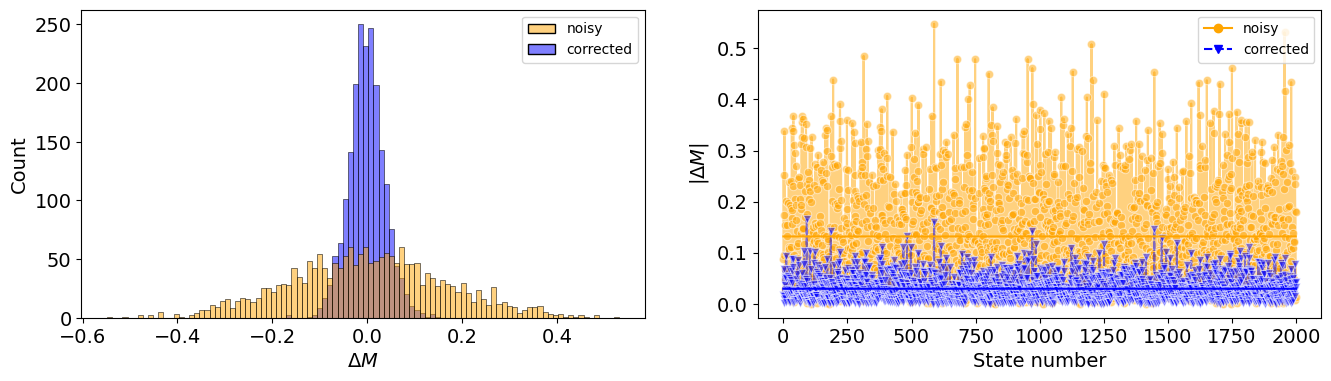

In [14]:
"""
Magnetization error histogram
"""

fix, ax = plt.subplots(1, 2, figsize=(16,4))
fontsize = 14
plt.subplot(1,2,1)

hist1 = sns.histplot(
    {
        'noisy':     np_error_before_nn,
        'corrected': np_error_after_nn
    },
    bins=100,
    palette={'noisy': 'orange', 'corrected': 'blue'}
)
hist1.set_xlabel(r'$\Delta M$', fontsize=fontsize)
hist1.set_ylabel(r'Count', fontsize=fontsize)
hist1.tick_params(labelsize=fontsize)

plt.subplot(1,2,2)

lineplot21 = sns.lineplot(
    {
     'noisy':     test_samples_error_before_nn,
     'corrected': test_samples_error_after_nn,
    },
    palette={'noisy': 'orange', 
             'corrected': 'blue'},
    markers=('o', 'v'),
    markersize=6,
    linestyle='',
    alpha=0.5
)

lineplot22 = sns.lineplot(
    {
     'before mean': mu_before_mean_array,
     'after mean':  mu_after_mean_array
    },
    palette={'before mean': 'orange', 
             'after mean': 'blue'},
    markers=False,
    alpha=0.99,
    legend=False,
    dashes=False
)
lineplot22.set_xlabel('State number', fontsize=fontsize)
lineplot22.set_ylabel(r'|$\Delta M$|', fontsize=fontsize)
lineplot22.tick_params(labelsize=fontsize)

plt.plot()

#### Figure B.2

[]

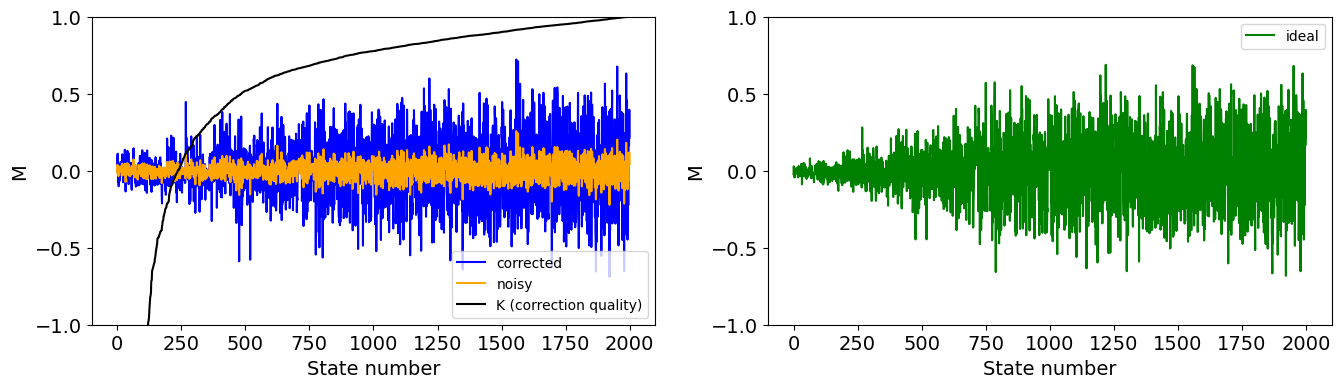

In [15]:
"""
States magnetization correction
"""

fix, ax = plt.subplots(1, 2, figsize=(16,4), sharey=False)

plt.subplot(1,2,1)
lineplot31 = sns.lineplot(
    {
        'corrected': M_corrected[ind_K_sorted],
        'noisy':     M_noisy[ind_K_sorted],
    },
    palette={'noisy': 'orange', 'corrected': 'blue'},
    dashes=False
)
lineplot32 = sns.lineplot(
    {
        'K (correction quality)': K_array[ind_K_sorted]
    },
    palette={'K (correction quality)': 'black'},
    dashes=True
)
plt.ylim(-1.0, 1.0)
lineplot31.set_xlabel('State number', fontsize=fontsize)
lineplot31.set_ylabel('M', fontsize=fontsize)
lineplot31.tick_params(labelsize=fontsize)


plt.subplot(1,2,2)
lineplot4 = sns.lineplot(
    {
        'ideal': M_ideal[ind_K_sorted],
    },
    palette={'ideal': 'green'},
    dashes=False
)
plt.ylim(-1.0, 1.0)
lineplot4.set_xlabel('State number', fontsize=fontsize)
lineplot4.set_ylabel('M', fontsize=fontsize)
lineplot4.tick_params(labelsize=fontsize)

plt.plot()

### Forward-in-time evolution results

In [16]:
# Noisy dynamics results
X_forward  = torch.from_numpy(test_data_loaded['data'][:,:,1,:])
# Noise-free dynamics results
y_forward  = torch.from_numpy(test_data_loaded['data'][:,:,0,:])
# Exact dynamics results
z_forward  = torch.from_numpy(test_data_loaded['data'][:,:,2,:])
# Transform from qubit excitations to spin magnetizations
X_forward = 2*X_forward - 1
y_forward = 2*y_forward - 1
z_forward = 2*z_forward - 1
with torch.no_grad():
    X_corrected = model(X_forward)
time_points = np.linspace(0, test_data_loaded['parameters']['total sim time'], test_data_loaded['parameters']['time points'])

In [17]:
M_average_ideal     = np.zeros(X_forward.shape[:2])
M_average_noisy     = np.zeros(X_forward.shape[:2])
M_average_corrected = np.zeros(X_forward.shape[:2])
M_average_exact     = np.zeros(X_forward.shape[:2])
N = X_forward.shape[-1]

for i, (x, y, y_, z) in enumerate(zip(X_forward, y_forward, X_corrected, z_forward)):
    M_average_noisy[i]     = x.sum(axis=1)/N
    M_average_ideal[i]     = y.sum(axis=1)/N
    M_average_corrected[i] = y_.sum(axis=1)/N
    M_average_exact[i]     = z.sum(axis=1)/N

In [18]:
K_forward_array = 1 - abs(M_average_ideal - M_average_corrected).sum(axis=1)/abs(M_average_ideal - M_average_noisy + eps).sum(axis=1)
ind_K_forward_sorted = np.argsort(K_forward_array)
K_forward_qubits_array = (1 - abs(y_forward - X_corrected).sum(axis=1)/abs(y_forward - X_forward + eps).sum(axis=1)).numpy()

In [19]:
K_ind = ind_K_forward_sorted[99]

M_k_ideal     = M_average_ideal[K_ind]
M_k_noisy     = M_average_noisy[K_ind]
M_k_corrected = M_average_corrected[K_ind]
M_k_exact     = M_average_exact[K_ind]

#### Figure 6

[]

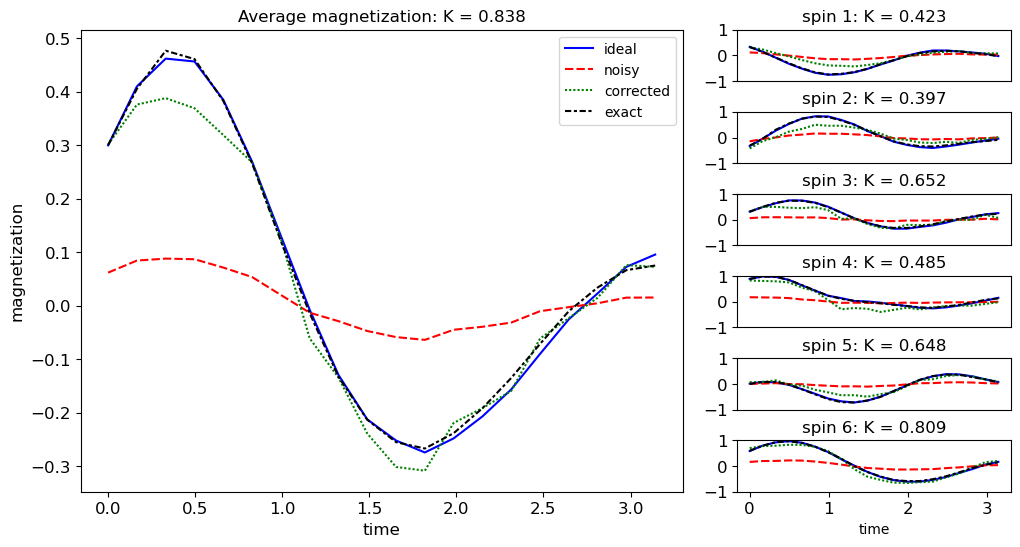

In [20]:
fontsize = 12
num_qubits = test_data_loaded['parameters']['num of qubits']

plt.figure(figsize=(12,6))
Grid_plot = plt.GridSpec(6, 3, wspace = 0.2,
                         hspace = 0.6)
 
for i in range(num_qubits):
    plt.subplot(Grid_plot[i, -1])
    df = pd.DataFrame(list(zip(time_points, 
                               y_forward[K_ind,:,i].numpy(),
                               X_forward[K_ind,:,i].numpy(),
                               X_corrected[K_ind,:,i].numpy(),
                               z_forward[K_ind,:,i].numpy())),
                      columns =['time', 'ideal', 'noisy', 'corrected', 'exact'])
    df.set_index('time', inplace=True)
    sns.lineplot(
        data=df, 
        palette={'ideal':'blue', 'corrected': 'green', 'exact': 'black', 'noisy': 'red'},
        legend=False)
    plt.ylim(-1.0, 1.0)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title(f"spin {i+1}: K = {round(K_forward_qubits_array[K_ind][i], 3)}")
    if i < 5: 
        plt.xlabel("")
        plt.xticks([])

plt.subplot(Grid_plot[:6, :-1])
df = pd.DataFrame(list(zip(time_points, 
                           M_k_ideal,
                           M_k_noisy,
                           M_k_corrected,
                           M_k_exact)),
                  columns =['time', 'ideal', 'noisy', 'corrected', 'exact'])
df.set_index('time', inplace=True)
sns.lineplot(
    data=df, 
    palette={'ideal':'blue', 'corrected': 'green', 'exact': 'black', 'noisy': 'red'}
)
plt.ylabel('magnetization', fontsize=fontsize)
plt.xlabel('time', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(f"Average magnetization: K = {round(K_forward_array[K_ind],3)}")

plt.plot()

#### Figure 7

[]

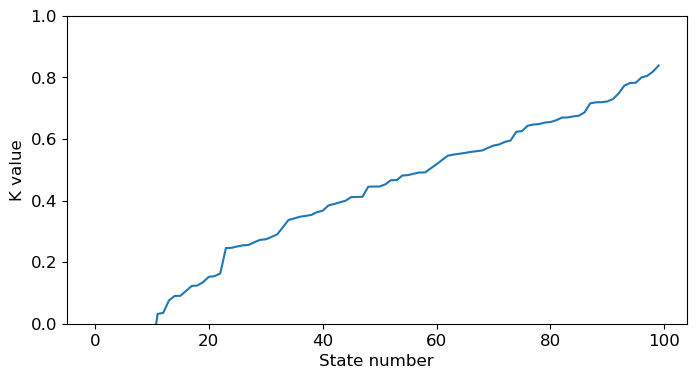

In [21]:
plt.figure(figsize=(8,4))

sns.lineplot(
    data=K_forward_array[ind_K_forward_sorted]
)
plt.ylim(0.0, 1.0)
plt.ylabel("K value", fontsize=fontsize)
plt.xlabel("State number", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.plot()

#### Figure 8

[]

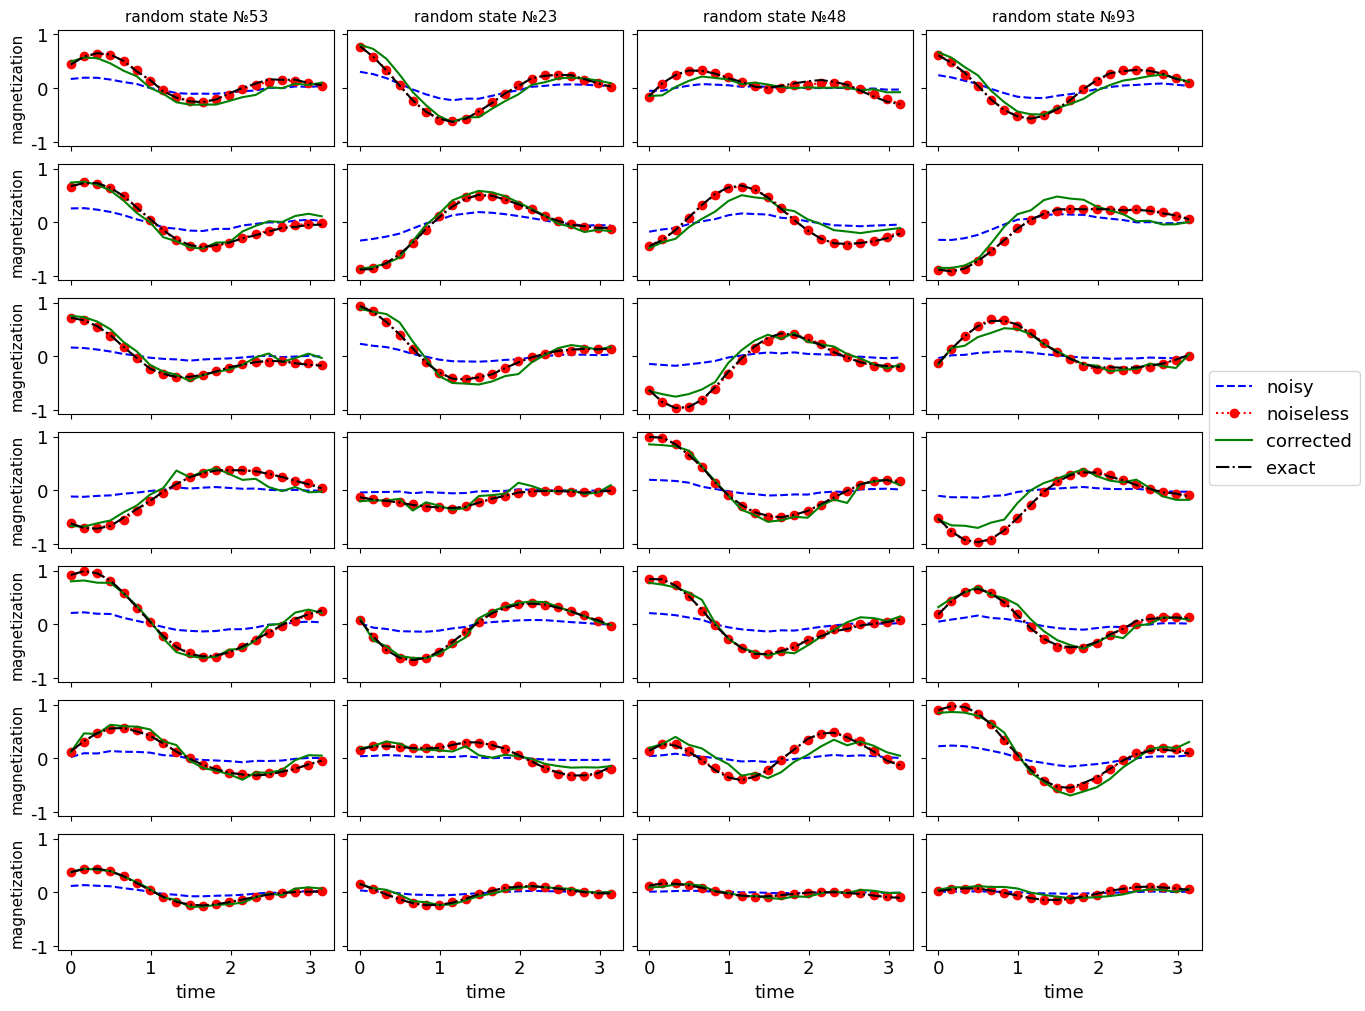

In [22]:
"""
# import random
# indices = random.sample(range(len(X_forward)), k=4)

To see how a trained network corrects dynamics of different initial states,
use random indices instead (code snippet above) of fixed ones, used in the paper. There will be
examples of bad correction (when a neural network even makes things worse).

This behaviour demonstrates that a neural network can correct quantum-computed
data only in average, with possible deterioration of observables quality for
some "hard" initial states. Simulation results demonstrate that such states have 
close to zero average spin magnetization. 

Consult to Fig. 6 bottom row, where low correction efficiency values K correlate 
to close to zero average magnetization values. A possible explanation: as depolzatizing 
noise, used in simulation, drives average magnetization towards zero, evolved states with
close to zero average magnetization stay "visibly intact" (although they are not). As 
neural network is trained to "restore the range" of the noise-affected observable, it is 
not able to work properly in that case unless a much larger data set with many examples of
such "hard-to-correct" states is used for training. A neural network efficiency thus can be 
possibly increased via collecting more training data, and thus with increasing of the 
training computational overhead (see https://arxiv.org/abs/2309.17368 for a good discussion
about "runtime" and "training" overhead in quantum error mitigation).
"""

indices = (53, 23, 48, 93)
fontsize = 15
num_qubits = test_data_loaded['parameters']['num of qubits']

fig, axs = plt.subplots(
    nrows=num_qubits+1, ncols=4, 
    layout='constrained', 
    figsize=(12,10),
    sharex=True, sharey=True
    )
for i, axes in enumerate(axs):
    if i < num_qubits:
        for j, ind in enumerate(indices):
            axes[j].plot(time_points, X_forward[ind,:,i],   linestyle='dashed',  label='noisy',     color="blue")
            axes[j].plot(time_points, y_forward[ind,:,i],   linestyle='dotted',  label='noiseless', color="red", marker='o')
            axes[j].plot(time_points, X_corrected[ind,:,i], linestyle='solid',   label='corrected', color="green")
            axes[j].plot(time_points, z_forward[ind,:,i],   linestyle='dashdot', label='exact',     color="black")             
            if i == 0:
                axes[j].set_title(f'random state №{ind}', fontsize=fontsize-4)
            if i == axs.shape[0]-1:
                axes[j].set_xlabel("time", fontsize=fontsize-2)
            if j == 0:
                axes[j].set_ylabel("magnetization", fontsize=fontsize-4)
                axes[j].set_yticks(ticks=[-1, 0, 1], labels=map(str, [-1, 0, 1]), fontsize=fontsize-2)
    else:
        for j, ind in enumerate(indices):
            axes[j].plot(time_points, M_average_noisy[ind,:], linestyle='dashed', label='noisy', color="blue")
            axes[j].plot(time_points, M_average_ideal[ind,:], linestyle='dotted', marker='o', label='noiseless', color="red")
            axes[j].plot(time_points, M_average_corrected[ind,:], linestyle='solid', label='corrected', color="green")
            axes[j].plot(time_points, M_average_exact[ind,:], linestyle='dashdot', label='exact', color="black")
            if i == 0:
                axes[j].set_title(f'random state №{ind}', fontsize=fontsize-4)
            if i == axs.shape[0]-1:
                axes[j].set_xlabel("time", fontsize=fontsize-2)
                axes[j].set_xticks(ticks=[0, 1, 2, 3], labels=map(str, [0, 1, 2, 3]), fontsize=fontsize-2)
            if j == 0:
                axes[j].set_ylabel("magnetization", fontsize=fontsize-4)
                axes[j].set_yticks(ticks=[-1, 0, 1], labels=map(str, [-1, 0, 1]), fontsize=fontsize-2)
text_str = '                   '
fig.text(1.02, 0.4, text_str, fontsize=fontsize)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.885, 0.52),
           frameon=True, fancybox=True, fontsize=fontsize-2)
           
plt.plot()

### Neural network size analysis

#### Upload data

In [73]:
import K_stats_functions
importlib.reload(K_stats_functions)

cwd = os.getcwd()
new_dir = cwd + '/paper_plots'

"""
Returns
    res_dict = {
    "train":        train_data_samples,
    "valid":        valid_data_samples,
    "test":         test_data_samples,
    "forward":      forward_data_samples,
    "time":         time_points,
    "models":       model_matrix_loaded,
    "train losses": train_losses_array,
    "valid losses": valid_losses_array
    }
"""

data_dir = cwd + '/data_q_000_J_half_h/opt_fixed'
data_000 = K_stats_functions.load_data(data_dir=data_dir)

data_dir = cwd + '/data_q_003_J_half_h/opt_fixed'
data_003 = K_stats_functions.load_data(data_dir=data_dir)

data_dir = cwd + '/data_q_007_J_half_h/opt_fixed_2'
data_007 = K_stats_functions.load_data(data_dir=data_dir)

data_dir = cwd + '/data_q_01_J_half_h/opt_fixed'
data_01 = K_stats_functions.load_data(data_dir=data_dir)

In [21]:
model_matrix_000 = data_000['models']
X_test_samples_array_000 = data_000['test']['X']
y_test_samples_array_000 = data_000['test']['Y']
M_K_000 = K_stats_functions.calculate_M_K_values_echo(model_matrix_000, X_test_samples_array_000, y_test_samples_array_000, eps=1e-2)

In [22]:
model_matrix_003 = data_003['models']
X_test_samples_array_003 = data_003['test']['X']
y_test_samples_array_003 = data_003['test']['Y']
M_K_003 = K_stats_functions.calculate_M_K_values_echo(model_matrix_003, X_test_samples_array_003, y_test_samples_array_003, eps=1e-2)

In [23]:
model_matrix_007 = data_007['models']
X_test_samples_array_007 = data_007['test']['X']
y_test_samples_array_007 = data_007['test']['Y']
M_K_007 = K_stats_functions.calculate_M_K_values_echo(model_matrix_007, X_test_samples_array_007, y_test_samples_array_007, eps=1e-2)

In [24]:
model_matrix_01 = data_01['models']
X_test_samples_array_01 = data_01['test']['X']
y_test_samples_array_01 = data_01['test']['Y']
M_K_01 = K_stats_functions.calculate_M_K_values_echo(model_matrix_01, X_test_samples_array_01, y_test_samples_array_01, eps=1e-2)

In [25]:
D_hidden_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 25, 50, 100, 200]

#### Figure 9

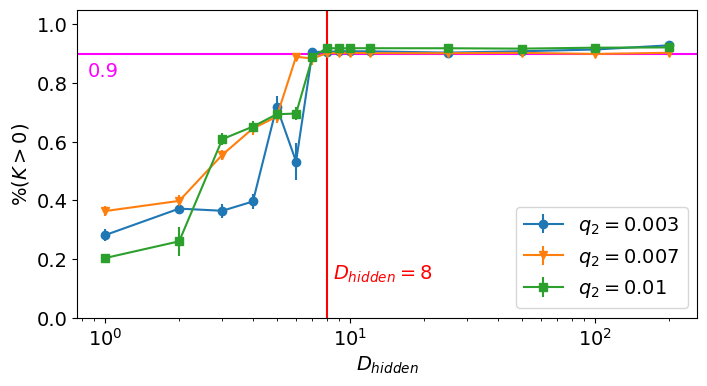

In [27]:
fontsize = 14

fix, ax = plt.subplots(1, 1, figsize=(8,4))

plt.subplot(1,1,1)

#plt.errorbar(x=D_hidden_lst, y=M_K_000['%K>0']['mean'], yerr=M_K_000['%K>0']['std'],  marker='o', label='q = 0.000')
plt.errorbar(x=D_hidden_lst, y=M_K_003['%K>0']['mean'], yerr=M_K_003['%K>0']['std'],  marker='o', label=r'$q_{2} = 0.003$')
plt.errorbar(x=D_hidden_lst, y=M_K_007['%K>0']['mean'], yerr=M_K_007['%K>0']['std'],  marker='v', label=r'$q_{2} = 0.007$')
plt.errorbar(x=D_hidden_lst, y=M_K_01['%K>0']['mean'],  yerr=M_K_01['%K>0']['std'],   marker='s', label=r'$q_{2} = 0.01$')

plt.xlabel(r'$D_{hidden}$', fontsize=fontsize)
plt.xscale('log')
plt.ylabel(r'$\%(K > 0)$', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xticks([1,10,100], fontsize=fontsize)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=fontsize)

plt.axvline(x=8, color='red')
plt.text(8.5, 0.15, r"$D_{hidden} = 8$", rotation=0, verticalalignment='center', color='red', fontsize=14)
plt.axhline(y=0.90, color='magenta')
plt.text(0.85, 0.84, "0.9", rotation=0, verticalalignment='center', color='magenta', fontsize=14)

plt.ylim(0.0, 1.05)

plt.show()

### Figure ???

/home/VNIIA/dvbabukhin/Загрузки/paper_code/data_q_003_J_half_h/test_data_10_trotters_T.pkl
/home/VNIIA/dvbabukhin/Загрузки/paper_code/data_q_007_J_half_h/test_data_10_trotters_T.pkl
/home/VNIIA/dvbabukhin/Загрузки/paper_code/data_q_01_J_half_h/test_data_10_trotters_T.pkl
/home/VNIIA/dvbabukhin/Загрузки/paper_code/data_q_011_J_half_h/test_data_10_trotters_T.pkl
/home/VNIIA/dvbabukhin/Загрузки/paper_code/data_q_012_J_half_h/test_data_10_trotters_T.pkl
/home/VNIIA/dvbabukhin/Загрузки/paper_code/data_q_013_J_half_h/test_data_10_trotters_T.pkl


[]

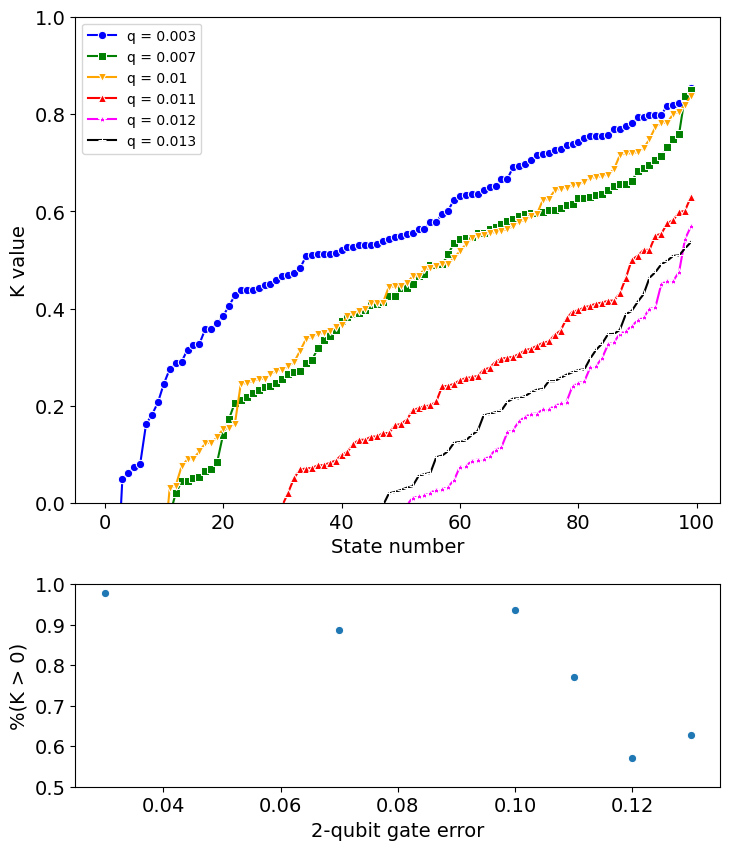

In [106]:
from matplotlib.gridspec import GridSpec

cwd = os.getcwd()

data_name = '/test_data_10_trotters_T'
T_postfix = data_name.split('_')[-1]

new_dir_array = [
    cwd + '/data_q_003_J_half_h',
    cwd + '/data_q_007_J_half_h',
    cwd + '/data_q_01_J_half_h',
    cwd + '/data_q_011_J_half_h',
    cwd + '/data_q_012_J_half_h',
    cwd + '/data_q_013_J_half_h'
]
markers = ['o', 's', 'v', '^', '*', '+']
colors  = ['blue', 'green', 'orange', 'red', 'magenta', 'black']
q_array = ['q = 0.003', 
           'q = 0.007', 
           'q = 0.01', 
           'q = 0.011', 
           'q = 0.012', 
           'q = 0.013']

eps = 1e-2
fontsize = 14

q_val_array = [0.03, 0.07, 0.1, 0.11, 0.12, 0.13]
K_pos_array = np.zeros(len(q_val_array))

gs = GridSpec(3, 1, left=0.05, right=0.48, wspace=0.0, hspace=0.4)
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(gs[:2,0])
for m, new_dir in enumerate(new_dir_array):
    
    print(new_dir + data_name + '.pkl')
    
    with open(new_dir + data_name + '.pkl', 'rb') as f:
        test_data_loaded = pickle.load(f)

    del test_data_loaded['parameters']['init state']

    D_in = X_train[0].shape[0]
    D_hidden = 200

    model     = nn_functions.generate_onelayer_model(D_in, D_hidden, out_f='tanh')
    #model     = nn_functions.generate_simple_model(D_in, D_hidden, out_f='tanh')
    model_name = f'spin_model_t{tn}_Dh_{D_hidden}_{T_postfix}'

    if not os.path.isdir(new_dir + '/' + model_name):
        os.mkdir(new_dir + '/' + model_name)

    epochs = 100
    tn = 5
    T_postfix = 'T'

    model_name = f'spin_model_t{tn}_Dh_{D_hidden}_{T_postfix}'
    model.load_state_dict(torch.load(new_dir + '/' + model_name + f'/model_{epochs}_epochs.pt'))
    criterion = nn.MSELoss()
    model.double()
    
    # Noisy dynamics results
    X_forward  = torch.from_numpy(test_data_loaded['data'][:,:,1,:])
    # Noise-free dynamics results
    y_forward  = torch.from_numpy(test_data_loaded['data'][:,:,0,:])
    # Exact dynamics results
    z_forward  = torch.from_numpy(test_data_loaded['data'][:,:,2,:])
    # Transform from qubit excitations to spin magnetizations
    X_forward = 2*X_forward - 1
    y_forward = 2*y_forward - 1
    z_forward = 2*z_forward - 1
    with torch.no_grad():
        X_corrected = model(X_forward)
    time_points = np.linspace(0, test_data_loaded['parameters']['total sim time'], test_data_loaded['parameters']['time points'])

    M_average_ideal     = np.zeros(X_forward.shape[:2])
    M_average_noisy     = np.zeros(X_forward.shape[:2])
    M_average_corrected = np.zeros(X_forward.shape[:2])
    M_average_exact     = np.zeros(X_forward.shape[:2])
    N = X_forward.shape[-1]

    for i, (x, y, y_, z) in enumerate(zip(X_forward, y_forward, X_corrected, z_forward)):
        M_average_noisy[i]     = x.sum(axis=1)/N
        M_average_ideal[i]     = y.sum(axis=1)/N
        M_average_corrected[i] = y_.sum(axis=1)/N
        M_average_exact[i]     = z.sum(axis=1)/N
    
    K_forward_array = 1 - abs(M_average_ideal - M_average_corrected).sum(axis=1)/abs(M_average_ideal - M_average_noisy + eps).sum(axis=1)
    ind_K_forward_sorted = np.argsort(K_forward_array)
    K_forward_qubits_array = (1 - abs(y_forward - X_corrected).sum(axis=1)/abs(y_forward - X_forward + eps).sum(axis=1)).numpy()

    K_ind = ind_K_forward_sorted[99]
    
    K_pos_array[m] = np.size(K_forward_qubits_array[K_forward_qubits_array > 0])/np.size(K_forward_qubits_array)

    sns.lineplot(
        data=K_forward_array[ind_K_forward_sorted],
        color=colors[m],
        marker=markers[m],
        label=q_array[m],
        ax=ax
    );
    plt.ylim(0.0, 1.0);
    plt.ylabel("K value", fontsize=fontsize);
    plt.xlabel("State number", fontsize=fontsize);
    plt.xticks(fontsize=fontsize);
    plt.yticks(fontsize=fontsize);
    
ax = fig.add_subplot(gs[2,0])
sns.lineplot(
    x=q_val_array,
    y=K_pos_array,
    linestyle='',
    marker='o',
    ax=ax
);
plt.ylim(0.0, 0.13);
plt.ylim(0.5, 1.0);
plt.ylabel("%(K > 0)", fontsize=fontsize);
plt.xlabel("2-qubit gate error", fontsize=fontsize);
plt.xticks(fontsize=fontsize);
plt.yticks(fontsize=fontsize);

plt.plot()